# 연관규칙(Associationi Rule)

> 항목들(item)간의 관계에서 규칙성을 찾는 방법으로, 어떤 사건들끼리 자주 함께 발생하는지, 서로 얼마나 연관되어 있는지 등을 알아보는 방법이다.

## 연관규칙 척도
> 지지도(support), 신뢰도(confidence), 향상도(lift)

### 지지도(support)
> 전체 경우의 수에서 두 아이템이 같이 나오는 비율

$$
지지도 = P(A\cap B) = \frac{A와 B 동시거래수}{전체 거래수}    =     \frac{A\cap B}{전체}
$$


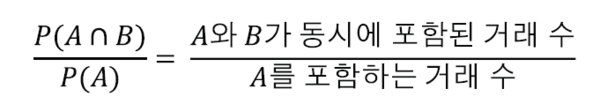
https://cdn.sbr.ai/news/photo/202201/1582_1214_1858.png

### 신뢰도(confidence)
> A를 포함한 거래 중 항목 A와 항목 B가 같이 포함될 확률

$$
신뢰도 = \frac{P(A\cap B)}{P(A)} = \frac{A와 B 동시거래수}{A를 포함하는 거래수}    =     \frac{지지도}{P(A)}
$$


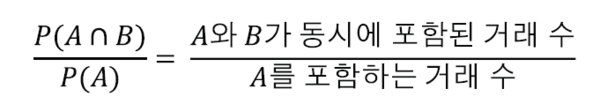

### 향상도(lift)
> A가 구매되지 않았을 때 품목 B의 구매확률 대비, A가 구매되었을 때 품목 B의 구매확률의 증가 비  
> A와 B의 독립여부 확인

$$
향상도 = \frac{P(A\cap B)}{P(A)P(B)} = \frac{P(B|A)}{P(B)} = \frac{신뢰도}{P(B)}
$$


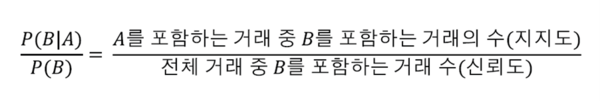
>> 1보다 클경우 양의 상관관계  
>> 1일 경우 상호 독립관계  
>> 1보다 작을경우 음의 상관관계

### 레버리지(leverage)
> 향상도에서는 비율을 이용해서 A와 B의 독립여부를 확인했다면, 레버리지는 차이를 이용해서 A와 B의 독립여부를 파악한다.

$$
향상도 = P(A\cap B) - P(A)P(B)
$$

# FP-Growth

https://process-mining.tistory.com/92  
Apriori와의 차이는 FP-Tree를 생성한 후에 최소 지지도 이상의 패턴만을 추출한다는 것이다.  
Apriori와 달리 빈발항목집합을 생성하지 않고, FP-Tree(Frequent Pattern Tree)를 만들어 Apriori 보다 더 빠르게 빈발항목집합을 추출할 수 있다.
Apriori의 아이템 갯수가 많아지면 계산 복잡도가 증가한다는 약점을 보완하기 위해 고안 된 것으로, 데이터베이스를 스캔하는 횟수가 적고, 빠른 속도로 분석이 가능하다.

## load dataset and preprosessing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import scipy.sparse as sparse
import random
import implicit
from implicit.als import AlternatingLeastSquares as ALS

%cd /home/user_3/medistream-recsys/Script
from preprocessing import drop_columns,dict_to_column,dict_to_set,set_to_column,key_to_element

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 100)

/home/user_3/medistream-recsys/Script


In [23]:
df = pd.read_json('/fastcampus-data/select_column_version_3.json')
# paid orders만 가져오기
df['date_paid'] = pd.to_datetime(df['date_paid'])
df_only_paid = df[~df['date_paid'].isna()]
# # 3개월치 데이터만 가져오기
df_date = df_only_paid[df_only_paid['date_paid'] > "2022-05-12"]
# 취소 안된 것만 가져오기
complete_df = df_date[(df_date['paid'] == True) & (df_date['cancelled']==False)]
complete_df = complete_df.reset_index(drop=True)
# 도서 카테고리만 가져오기
df_book = complete_df[complete_df['name'] == '도서']
df_book = df_book.sort_values(by='date_paid')
# 이상치 제거: 국시특강, 보수교육
df_book = df_book[df_book['name_x'].str.contains('국시특강') == False]
df_book = df_book[df_book['name_x'].str.contains('보수교육') == False]
# 전체
# df_book = complete_df[complete_df['name'].isin(['도서','소모품'])].sort_values(by='date_paid')

In [24]:
df_book.isna().sum(), df_book.shape

(_id                0
 date_paid          0
 customer_id        0
 paid               0
 name_x             0
 category_id_y      0
 product_ids        0
 quantity           0
 price              0
 price_total        0
 age_group        907
 한의사 여부             1
 사업자 여부             1
 cancelled          0
 name               0
 slug               0
 dtype: int64,
 (5931, 16))

In [25]:
# customer 별로 구입한 책 목록 뽑기
transactions = [ list(a[1]['name_x']) for a in list(df_book.groupby(['customer_id']))]

In [26]:
a = 0
b = 0
c = 0
for i in range(len(transactions)):    
    if len(transactions[i]) >= 2:
        a += 1
    if len(transactions[i]) >= 3:
        b += 1
    if len(transactions[i]) >= 4:
        c += 1

print('2개 이상 구매한 고객 수: ', a)
print('3개 이상 구매한 고객 수: ', b)
print('4개 이상 구매한 고객 수: ', c)

2개 이상 구매한 고객 수:  1239
3개 이상 구매한 고객 수:  668
4개 이상 구매한 고객 수:  404


# Train_Test_Split
마지막 3주 분량을 test로 선정합니다.  
train 3번 이상 구매 유저에 대해서만 학습을 진행합니다.  
test 3번이상 구매 유저를 대상으로 최근 3번 구매한 기록까지 예측을 진행합니다.  
train 있는 유저만을 test 평가를 진행합니다.

In [54]:
### 원본
from datetime import datetime, timedelta

date = df_book['date_paid'].max()-timedelta(weeks=3)
## 기간에 따라 나누기
train_before_preprocess = df_book[df_book['date_paid'] < date]
test_before_preprocess = df_book[df_book['date_paid'] >= date]
## train 
# train 3개 이상 구매 기록유저에 대한 학습 진행
# 전처리할 train index 확인
train_drop_row_index = train_before_preprocess['customer_id'].value_counts()[train_before_preprocess['customer_id'].value_counts()>2].index
train = train_before_preprocess[train_before_preprocess['customer_id'].isin(train_drop_row_index)]

## test
# 전처리할 test index 확인
drop_row_index = test_before_preprocess['customer_id'].value_counts()[test_before_preprocess['customer_id'].value_counts()>2].index

# 최근 구매한 아이템 3개를 test 데이터로 사용
test_list = []
for idx in drop_row_index:
    test_list.append(test_before_preprocess[test_before_preprocess['customer_id']==idx].iloc[:3])
test = pd.concat(test_list)

# train 있는 유저에 대해서만 진행
test = test[test['customer_id'].isin(train['customer_id'])]

In [49]:
from datetime import datetime, timedelta

date = df_book['date_paid'].max()-timedelta(weeks=3)
## 기간에 따라 나누기
train_before_preprocess = df_book[df_book['date_paid'] < date]
test_before_preprocess = df_book[df_book['date_paid'] >= date]

#### train 

# 전처리할 train index 확인
train_drop_row_index = train_before_preprocess['customer_id'].value_counts()[train_before_preprocess['customer_id'].value_counts()>2].index

# train 3개 이상 구매 기록유저에 대한 학습 진행
train = train_before_preprocess[train_before_preprocess['customer_id'].isin(train_drop_row_index)]

#### test
# 전처리할 test index 확인
drop_row_index = test_before_preprocess['customer_id'].value_counts()[test_before_preprocess['customer_id'].value_counts()>2].index

# 최근 구매 3개 기록을 test 사용
test = test_before_preprocess[test_before_preprocess['customer_id'].isin(drop_row_index)]

# train 있는 유저에 대해서만 진행
test = test[test['customer_id'].isin(train['customer_id'])]

In [56]:
print('train 유저 수:',len(train.customer_id.unique()))

train 유저 수: 565


In [57]:
print('test 유저 수:',len(test.customer_id.unique()))

test 유저 수: 16


## 원핫 인코딩 형태로 데이터프레임 생성

In [6]:
# !pip install mlxtend

In [60]:
pd.set_option('display.max_colwidth', -1)
transactions = [a[1]['name_x'].tolist() for a in list(train.groupby(['customer_id','date_paid']))]

<ipython-input-60-85e7ad1af8c7>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [61]:
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)

In [62]:
df = pd.DataFrame(te_array, columns=te.columns_)

df

,2022 통장잔고 2배 늘려주는 병의원 절세비법,Cyriax 정형의학 3판,HAPPY 소아청소년 진료,K. 한의학 임상총론,KCD 한방내과 진찰진단 가이드라인,Kendall 자세와 통증치료에 있어서 근육의 기능과 검사 5판,Medical acupuncture '침의 과학적 접근과 임상활용',NEO 인턴 핸드북,Netters 근육뼈대계 간결해부학,SMART 기본 일차진료매뉴얼 3판(세트),"SMART 내과 1권 : 바이탈, 감염, 종양, 류마티스",SMART 소아진료매뉴얼 3판,SMART 응급진료매뉴얼(세트),SMART 일차진료매뉴얼,"THE NETTER COLLECTION: VOL7 신경계통, 2판 (2권 Set)",The DOs (한국어판),"[세트] 말초신경 약침의학, 근골격계 약침의학","藥徵, 약의 징표",趙紹琴(조소금) 내과학,간단 한방처방,간단 한방철칙,감별진단의 정석,갑상선 진료 완전정복,개원의를 위한 통증사냥법,경계 너머의 한방처방,경락경혈 피로처방전,경락도해,경락상관론,경혈 MAP,경혈해설,고령자 한방진료,고장 난 뇌,귤창서영,그린만의 수기의학 원리,그림과 사진으로 보는 질환별 통증치료 Essential,그림으로 보는 뇌와 신경,그림으로 이해하는 수분과 전해질 및 산-염기 대사,근골격 초음파학,근골격계 물리치료 중재학 운동치료 테크닉,근골격계 약침의학,"근골격계 질환의 진단 및 재활치료, 4판",근골격계 초음파 정석(Musculoskeletal Ultrasound),근골격계 통증 및 질환에 대한 임상 시술제요,근막시스템의 기능해부학,근삼침,근육학,"금침, 10년이 젊어진다 - 통증이 사라지고 피부가 살아나는 금실 매선",기본통증진료학,나가노식 치료,나의 갑상선 진료,...,침구과 진료매뉴얼,침구대성,침의 과학적 접근의 이해,카이로프랙틱 기본테크닉론,토털매선의학,통증백해(痛症百解),통증의학 5판,통증의학을 위한 근골격계초음파 해부학,통증진단의 정석,통증초음파 실전 22례,통증치료를 위한 근육 초음파와 주사 테크닉,통증치료를 위한 신경초음파와 하이드로다이섹션 테크닉,통증치료를 위한 알기 쉬운 근골격계 이학적 검사법,트리거포인트 침치료,파킨슨 증후군 알아야 이긴다,파킨슨병 한의진료,평주온열경위,플로차트 정신질환의 한방치료,플로차트 정형외과 진단,플로차트 한약치료,피부질환 임상아틀라스,피부질환의 한의학치료 57증례,필라테스 해부학(PILATES ANATOMY),하루10분운동으로 100세 건강지키기,한권으로 끝내는 스테로이드치료,한눈에 보는 근력운동 해부학,한눈에 보는 스트레칭 해부학,한방 123처방 임상 해설,한방 활용 가이드,한방순환 신경내과학,한방임상이야기 제3권,한방처방정석,한방치료 44철칙,한방피부진료레슨,한약의 임상과 응용,한의 피부진료 첫 걸음,한의사를 위한 통증치료 매뉴얼 Part 3,한의통합종양학,한의학 상담,한의학치료 368증례,항생제 열전,핸즈온 허리,현동의감,현동의감 세트,호희서 금궤요략강의,호희서 상한론강의,환자상담의 달인,황황교수의 개원 한의사를 위한 상한금궤 처방 강의록,황황교수의 임상의를 위한 근거기반 상한금궤 처방 매뉴얼,흔히보는 정형외과 외래진료 가이드북
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,

In [71]:
from mlxtend.frequent_patterns import fpgrowth
fpgrowth = fpgrowth(df, min_support=0.01, use_colnames=True)

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [72]:
fpgrowth.sort_values(by = ['support'], ascending = False).head(15)

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets
8,0.120301,(비만문답)
9,0.104106,(플로차트 정형외과 진단)
0,0.090804,(흔히보는 정형외과 외래진료 가이드북)
6,0.075188,(황황교수의 임상의를 위한 근거기반 상한금궤 처방 매뉴얼)
7,0.071718,(황황교수의 개원 한의사를 위한 상한금궤 처방 강의록)
38,0.058415,"(황황교수의 임상의를 위한 근거기반 상한금궤 처방 매뉴얼, 황황교수의 개원 한의사를 위한 상한금궤 처방 강의록)"
15,0.046270,(사암침의 해석과 임상)
5,0.041064,(카이로프랙틱 기본테크닉론)
23,0.040486,(외래에서 꼭 알아야 할 통증증후군 137가지)
1,0.039907,(약침의 정석 –통증편)


# Calculate Association Rules

In [73]:
from mlxtend.frequent_patterns import association_rules
rules_confidence = association_rules(fpgrowth, min_threshold=0.01) # default가 confidence
rules_lift = association_rules(fpgrowth, metric= "lift", min_threshold=0.01)
# display(rules_lift.tail())
display(rules_confidence)

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(뇌의학의 첫걸음),(신경학 증상의 감별법),0.017929,0.023135,0.010411,0.580645,25.098387,0.009996,2.329448
1,(신경학 증상의 감별법),(뇌의학의 첫걸음),0.023135,0.017929,0.010411,0.450000,25.098387,0.009996,1.785583
2,(황황교수의 임상의를 위한 근거기반 상한금궤 처방 매뉴얼),(황황교수의 개원 한의사를 위한 상한금궤 처방 강의록),0.075188,0.071718,0.058415,0.776923,10.833065,0.053023,4.161265
3,(황황교수의 개원 한의사를 위한 상한금궤 처방 강의록),(황황교수의 임상의를 위한 근거기반 상한금궤 처방 매뉴얼),0.071718,0.075188,0.058415,0.814516,10.833065,0.053023,4.985943
4,(사암침의 해석과 임상),(비만문답),0.046270,0.120301,0.030654,0.662500,5.507031,0.025087,2.606516
5,(비만문답),(사암침의 해석과 임상),0.120301,0.046270,0.030654,0.254808,5.507031,0.025087,1.279845
6,(신경학 증상의 감별법),(갑상선 진료 완전정복),0.023135,0.024291,0.013302,0.575000,23.670833,0.012741,2.295785
7,(갑상선 진료 완전정복),(신경학 증상의 감별법),0.024291,0.023135,0.013302,0.547619,23.670833,0.012741,2.159386
8,(신경학 증상의 감별법),(약침의 정석 –통증편),0.023135,0.039907,0.010411,0.450000,11.276087,0.009487,1.745623
9,(약침의 정석 –통증편),(신경학 증상의 감별법),0.039907,0.023135,0.010411,0.260870,11.276087,0.009487,1.321641


## Recommend Items Purchased

In [75]:
apriori_items = rules_confidence[['antecedents','consequents']].iloc[:15]

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [76]:
test[['customer_id','name_x','product_ids']]

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,name_x,product_ids
52876,5ff7fdc7d6491c001b1785f6,적방! 한약처방 100문 100답,5f9676b2512031633431fa6b
52875,5ff7fdc7d6491c001b1785f6,고령자 한방진료,5e4ccce44267e105dfff1e99
52874,5ff7fdc7d6491c001b1785f6,음양승강으로 해석하는 사상의학: 생리병리,61e777f57c9ea1003fa99d6f
54823,602ac6c22c593a001acea9c9,트리거포인트 침치료,617a3aacbc63410023471ab6
54822,602ac6c22c593a001acea9c9,Medical acupuncture '침의 과학적 접근과 임상활용',5d784bac19efa30eb29143d0
54821,602ac6c22c593a001acea9c9,근골격계 약침의학,6005151da6432d001a69b21b
54750,5d9708790dabe405b156dccc,감별진단의 정석,60f8dba1d26af90681b1d066
54746,5d9708790dabe405b156dccc,신경학 증상의 감별법,628ecd6a9d9388002406f05a
54747,5d9708790dabe405b156dccc,The 정형내과(The Orthopaedic Medicine),5e3d02de4267e105dfff13dd
56598,60239968527223001a208810,"실전, 임상한의학 내과질환을 중심으로",6285af5e9d9388002406533f


In [77]:
apriori_items['antecedents'] = apriori_items['antecedents'].apply(lambda x: list(map(str,x))[0])
apriori_items['consequents'] = apriori_items['consequents'].apply(lambda x: list(map(str,x))[0])
train_items['apriori_pred'] = train_items['name_x'].apply(lambda x: apriori_items[apriori_items['antecedents']==x]['consequents'].values[0] if x in list(apriori_items['antecedents']) \
                            else None)

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'train_items' is not defined